In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# Clustering

In your social networks, your friends are probably more likely to be friends with each other than pure randomness would imply. There are various ways to quantify this precisely, but one of the easiest is the **local clustering coefficient**, defined for a node $i$ as

$$
C(i) = \frac{ 2 T(i) }{d_i(d_i-1)}.
$$

In this formula, $d_i$ is the degree of the node and $T(i)$ is the number of edges between node $i$'s neighbors. If $d_i=0$ or $d_i=1$, we set $C(i)=0$.

Equivalently, $T(i)$ is the number of triangles in the graph that pass through node $i$. Because the subgraph of the neighbors has

$$
\binom{d_i}{2}
$$

possible edges, the value of $C(i)$ is between 0 and 1.

Here is a wheel graph to help us explore a bit:

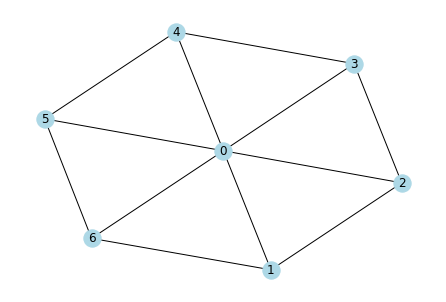

In [2]:
W = nx.wheel_graph(7)
nx.draw(W,with_labels=True,node_color="lightblue")

::::{prf:example}
:label: example-small-world-clustering
Find the clustering coefficient for each node in the wheel graph drawn above.
:::{dropdown} Solution
Node 0 in this graph is adjacent to 6 other nodes, and there are 6 triangles passing through it. Thus, its clustering coefficient is

$$
C(0) = \frac{6}{6 \cdot 5 / 2} = \frac{2}{5}.
$$

Every other node has 3 friends and 2 triangles, so they each have

$$
C(i) = \frac{2}{3 \cdot 2 / 2} = \frac{2}{3}, \quad i\neq 0.
$$
:::
::::

In NetworkX, we can manually count the number of edges among neighbors of node 0 by examining their subgraph.

6 edges among neighbors of node 0


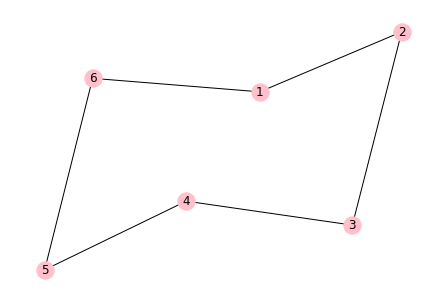

In [3]:
    nbrhood = W.subgraph(W[0])  # does not include node 0 itself
    print(nbrhood.number_of_edges(),"edges among neighbors of node 0")
    nx.draw(nbrhood,with_labels=True,node_color="pink")

More directly, the `clustering` function in NetworkX computes $C(i)$ for any single node, or for all the nodes in a graph.

In [4]:
print("node 0 clustering =",nx.clustering(W,0))
print("\nclustering at each node:")
print(pd.Series(nx.clustering(W),index=W.nodes))

node 0 clustering = 0.4

clustering at each node:
0    0.400000
1    0.666667
2    0.666667
3    0.666667
4    0.666667
5    0.666667
6    0.666667
dtype: float64


In addition, the `average_clustering` function will take the average over all nodes of the local clustering values.

In [5]:
print("average clustering =",nx.average_clustering(W))

average clustering = 0.6285714285714284


## ER graphs

Let's compute average clustering within multiple ER random graphs.

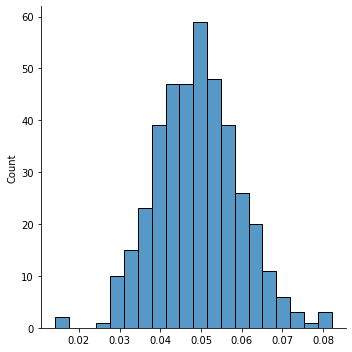

In [6]:
n,p = 121,1/20
results = []
for iter in range(400):
    ER = nx.erdos_renyi_graph(n,p,seed=iter+5000)
    results.append(nx.average_clustering(ER))

sns.displot(x=results);

The distribution above can't be normal, because there are hard bounds at 0 and 1, but it looks similar to a normal distribution. The peak is at the value of $p$ used in the simulation, which is not a coincidence.

````{prf:theorem}
:label: theorem-clustering-ER
The expected value of the average clustering in ER graphs of type $(n,p)$ is $p$.
````

A formal proof is largely superfluous; considering that each edge in the graph has a probability $p$ of inclusion, that is also the expected fraction of edges that appear within the neighborhood subgraph of any node. 

## Twitch network

Let's examine clustering within the Twitch network.

In [7]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
n,e = twitch.number_of_nodes(),twitch.number_of_edges()
kbar = 2*e/n
print(n,"nodes and",e,"edges")
print(f"average degree is {kbar:.3f}")

7126 nodes and 35324 edges
average degree is 9.914


Computing the distances between all pairs of nodes in this graph would take a rather long time, so we will estimate the average distance by sampling.

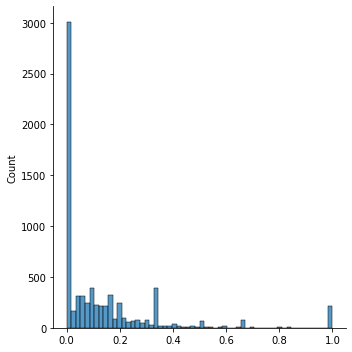

In [8]:
cluster = pd.Series(nx.clustering(twitch),index=twitch.nodes)
sns.displot(data=cluster);

The average clustering coefficient is

In [9]:
print("average Twitch clustering:",cluster.mean())

average Twitch clustering: 0.13092821901472096


How does this value compare to an ER graph? If we set the number of nodes and average degree to be the same, then the expected average clustering for ER graphs is $p=\bar{k}/(n-1)$:

In [10]:
print("average equivalent ER clustering:",kbar/(n-1))

average equivalent ER clustering: 0.0013914550620165345


This is too small by a factor of 100! Clearly, the Twitch graph is not equivalent to a random graph in the sense of ER. From a sociological perspective, of course, this is a "no duh" conclusion.

## Watts–Strogatz graphs

A **Watts–Strogatz graph** (WS graph) tries to model the small-world phenomenon. A WS graph has three parameters: $n$, an even integer $k$, and a probability $q$.

Imagine $n$ nodes arranged in a circle. Connect each node with an edge to each of its $k/2$ left neighbors and $k/2$ right neighbors. Now we "rewire" some of the edges by visiting each node $i$ in turn. For each edge from $i$ to a neighbor, with probability $q$ replace it with an edge between $i$ and a node chosen at random from all the nodes $i$ is not currently connected to. The idea is to start with tight-knit, overlapping communities, and randomly toss in some far-flung links.

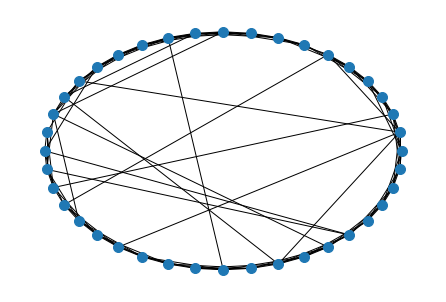

In [11]:
WS = nx.watts_strogatz_graph(40,6,0.15,seed=1)
nx.draw_circular(WS,node_size=100)

By the nature of the construction, the initial state of the network (before the rewiring phase) is highly clustered. Thus, if $q$ is close to zero, the final graph will retain much of this initial clustering.

Mean clustering in WS graphs on 60 nodes:


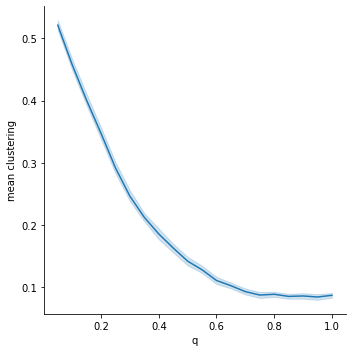

In [12]:
n,k = 60,6
results = []
seed = 0
for q in np.arange(0.05,1.05,0.05):
    for iter in range(50):
        WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
        results.append( (q,nx.average_clustering(WS)) )
        seed += 1
        
results = pd.DataFrame(results,columns=["q","mean clustering"])

print("Mean clustering in WS graphs on 60 nodes:")
sns.relplot(data=results,x="q",y="mean clustering",kind="line");

Let's scale the experiment above up to the size of the Twitch network. Conveniently, the average degree is nearly 10, which is the value we will use in the WS construction. To save computation time, we will use just one WS realization at each value of $q$.

In [13]:
seed = 99999
n,k = twitch.number_of_nodes(),10
for q in np.arange(0.15,0.61,0.05):
    WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
    print(f"q = {q:.2f}, avg WS clustering = {nx.average_clustering(WS):.4f}")
    seed += 1

q = 0.15, avg WS clustering = 0.4143
q = 0.20, avg WS clustering = 0.3418


q = 0.25, avg WS clustering = 0.2870
q = 0.30, avg WS clustering = 0.2326


q = 0.35, avg WS clustering = 0.1809
q = 0.40, avg WS clustering = 0.1470


q = 0.45, avg WS clustering = 0.1112
q = 0.50, avg WS clustering = 0.0851


q = 0.55, avg WS clustering = 0.0627
q = 0.60, avg WS clustering = 0.0424


The mean clustering resembles the value of 0.131 for the Twitch network at around $q=0.42$, which we verify using more realizations:

In [14]:
seed = 999
n,k,q = twitch.number_of_nodes(),10,0.42
cbar = []
for iter in range(10):
    WS = nx.watts_strogatz_graph(n,k,q,seed=seed)
    cbar.append(nx.average_clustering(WS))
    seed += 10
print("avg WS clustering at q = 0.42:",np.mean(cbar))

avg WS clustering at q = 0.42: 0.13177740621327544


The WS construction gives a plausible way to reconstruct the clustering observed in the Twitch network. However, there are other graph properties left to examine.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_semhalkh&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_kpsoxvsx" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>